In [5]:
from experiments.independent import Result
from experiments.independent.correlations import correlation_heatmap
from krippendorff import krippendorff
from scipy.stats import spearmanr, norm, ttest_ind
import matplotlib.pyplot as plt
import numpy as np

In [6]:
base_dir = "../../out/nonshuffled/MNIST"

# Sanity Checks for Saliency Metrics
## 1) Inter-rater reliability: Krippendorff Alpha
Calculate Krippendorff Alpha for each metric, by averaging values where necessary to create a single metric score per image.
This class of reliability assesses how consistent a saliency metric is in its scores between different images.

In [9]:
for dirname in (base_dir, f"{base_dir}_softmax", f"{base_dir}_lsm"):
    result_obj = Result(dirname)
    metrics = [m for m in result_obj.metric_names if m not in ("impact", "s-impact")]

    print(dirname)
    for metric in metrics:
        data = np.stack(
            [result_obj.aggregate(method, metric) 
             for method in result_obj.method_names],
            axis=1)
        print(f"{metric} krippendorff alpha:\t{krippendorff(np.argsort(data)):.3f}")
    print()

../../out/nonshuffled/MNIST
infidelity krippendorff alpha:	0.101
deletion krippendorff alpha:	0.129
insertion krippendorff alpha:	0.103
del-until-flip krippendorff alpha:	0.162
max-sens krippendorff alpha:	0.920
sens-n krippendorff alpha:	0.126

../../out/nonshuffled/MNIST_softmax
infidelity krippendorff alpha:	0.099
deletion krippendorff alpha:	0.102
insertion krippendorff alpha:	0.042
del-until-flip krippendorff alpha:	0.065
max-sens krippendorff alpha:	0.370
sens-n krippendorff alpha:	0.025

../../out/nonshuffled/MNIST_lsm
infidelity krippendorff alpha:	0.137
deletion krippendorff alpha:	0.090
insertion krippendorff alpha:	0.101
del-until-flip krippendorff alpha:	0.094
max-sens krippendorff alpha:	0.865
sens-n krippendorff alpha:	0.111



Do the same, but for bootstrapped samples.

In [10]:
for dirname in (base_dir, f"{base_dir}_softmax", f"{base_dir}_lsm"):
    result_obj = Result(dirname)
    metrics = [m for m in result_obj.metric_names if m not in ("impact", "s-impact")]
    print(dirname)
    for metric in metrics:
        data = np.stack(
            [result_obj.bootstrap(method, metric, sample_size=150, num_samples=2000)
             for method in result_obj.method_names],
            axis=1)
        print(f"{metric} krippendorff alpha:\t{krippendorff(np.argsort(data)):.3f}")
    print()

../../out/nonshuffled/MNIST
infidelity krippendorff alpha:	0.155
deletion krippendorff alpha:	0.223
insertion krippendorff alpha:	0.500
del-until-flip krippendorff alpha:	0.959
max-sens krippendorff alpha:	1.000
sens-n krippendorff alpha:	0.365

../../out/nonshuffled/MNIST_softmax
infidelity krippendorff alpha:	0.710
deletion krippendorff alpha:	0.923
insertion krippendorff alpha:	0.073
del-until-flip krippendorff alpha:	0.887
max-sens krippendorff alpha:	1.000
sens-n krippendorff alpha:	0.577

../../out/nonshuffled/MNIST_lsm
infidelity krippendorff alpha:	0.252
deletion krippendorff alpha:	0.141
insertion krippendorff alpha:	0.556
del-until-flip krippendorff alpha:	0.957
max-sens krippendorff alpha:	1.000
sens-n krippendorff alpha:	0.426



## 2) Inter-method reliability
Inter-method reliability assesses whether a saliency metric agrees across different saliency methods. This can be measured by taking the pairwise correlations between the scores of the different saliency methods on the data set images. If the scores of each saliency method fluctuate similarly between images, these correlations will be high, indicating high inter-method reliability. We use Spearman’s ρ to measure these pair-wise correlations.

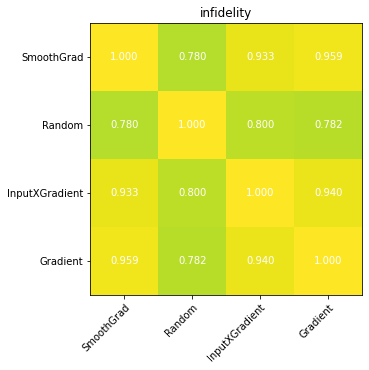

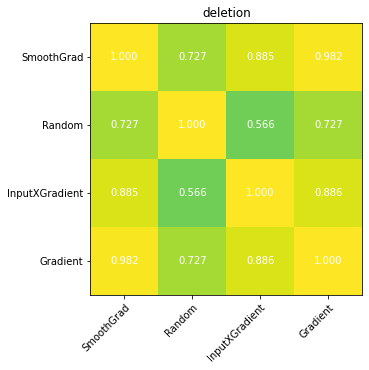

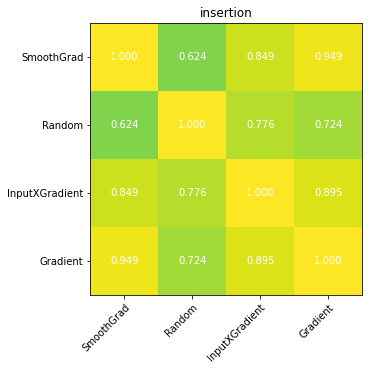

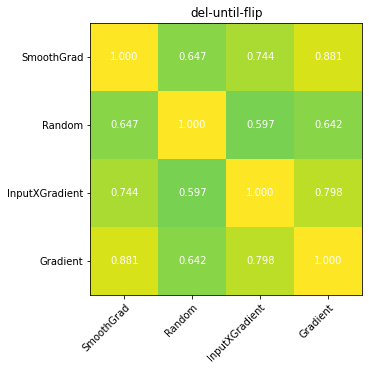

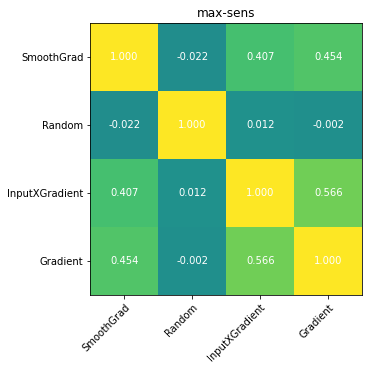

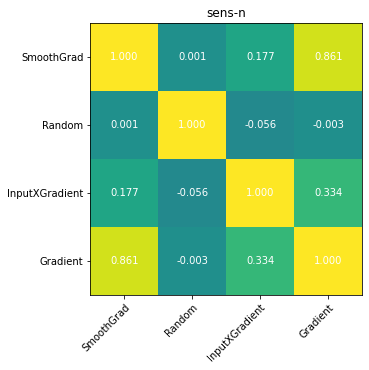

In [5]:
for metric in metrics:
    data = np.stack(
        [result_obj.aggregate(method, metric)
         for method in result_obj.method_names],
        axis=0)
    corrs = spearmanr(data, axis=1)[0]
    fig, ax = plt.subplots(figsize=(5, 5))
    correlation_heatmap(ax, corrs, result_obj.method_names, metric)

## 3) Internal consistency
Internal consistency reliability indicates whether different saliency metrics are capturing the same underlying concept (saliency map fidelity). This can be measured by taking the correlation between the scores produced by different metrics over saliency maps produced by the same saliency method. Again, we use Spearman’s ρ to measure this.

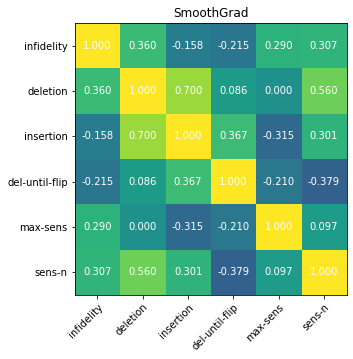

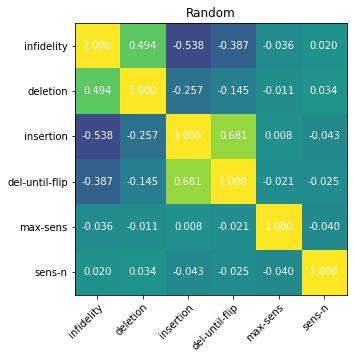

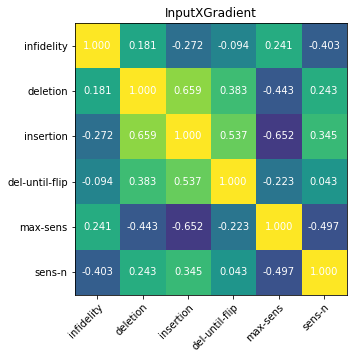

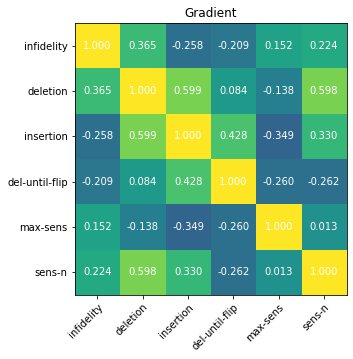

In [6]:
for method in result_obj.method_names:
    reduced_metrics = [m for m in metrics if m != "i-coverage"]
    data = np.stack(
        [result_obj.aggregate(method, metric)
         for metric in reduced_metrics],
        axis=0)
    corrs = spearmanr(data, axis=1)[0]
    fig, ax = plt.subplots(figsize=(5, 5))
    correlation_heatmap(ax, corrs, reduced_metrics, method)

# Pairwise t-tests
Another approach to quantify if a method scores better on a given metric, is to look at the distribution of scores and performing pairwise t-tests for every pair of methods. If the means are significantly different, we can say that one method scores significantly better than another on the given metric. Note that this is independent of the metric quality itself: if one method scores significantly better than another on a given metric, but that metric is not sound, this says nothing about the quality of the methods.

In [7]:
pass